In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from feature_engine.creation import CyclicalFeatures

In [2]:
filename = '../Datasets/AirQualityUCI_ready.csv'
variables = ['Date_Time','CO_sensor','RH']
data = pd.read_csv(filename,usecols=variables,index_col=['Date_Time'])
data.head(5)

,CO_sensor,RH
Date_Time,,
10/03/2004 18:00:00,1360.0,48.9
10/03/2004 19:00:00,1292.0,47.7
10/03/2004 20:00:00,1402.0,54.0
10/03/2004 21:00:00,1376.0,60.0
10/03/2004 22:00:00,1272.0,59.6


In [16]:
data.index = pd.to_datetime(data.index, format='%d/%m/%Y %H:%M:%S')
##  We also can sort the data 
data.sort_index(inplace=True)

# Reduce the data span 
data = data.loc['2004-04-04':'2005-04-04']


###  Get the min and max 
print(data.index.min())
print(data.index.max())

2004-04-04 00:00:00
2005-04-04 14:00:00


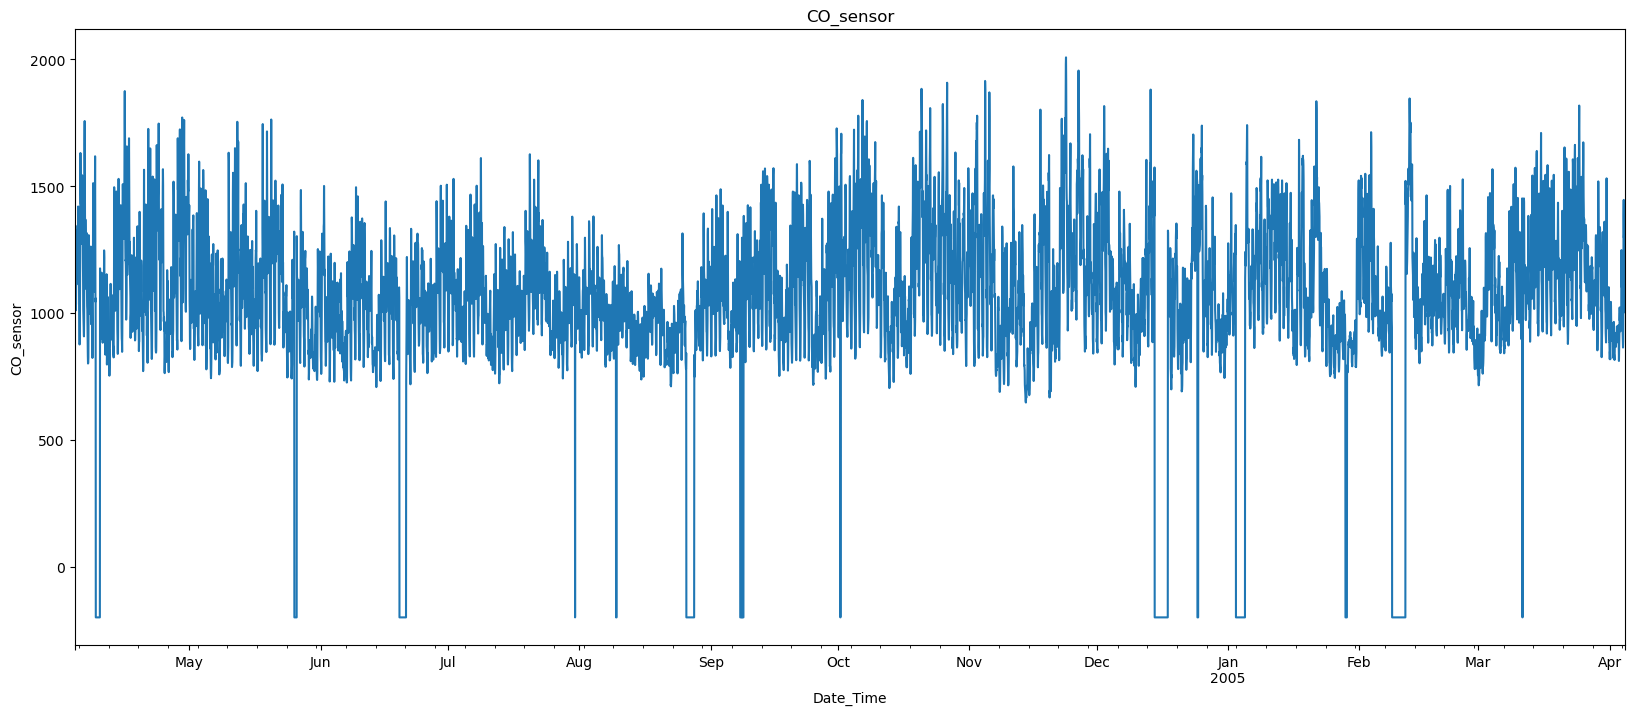

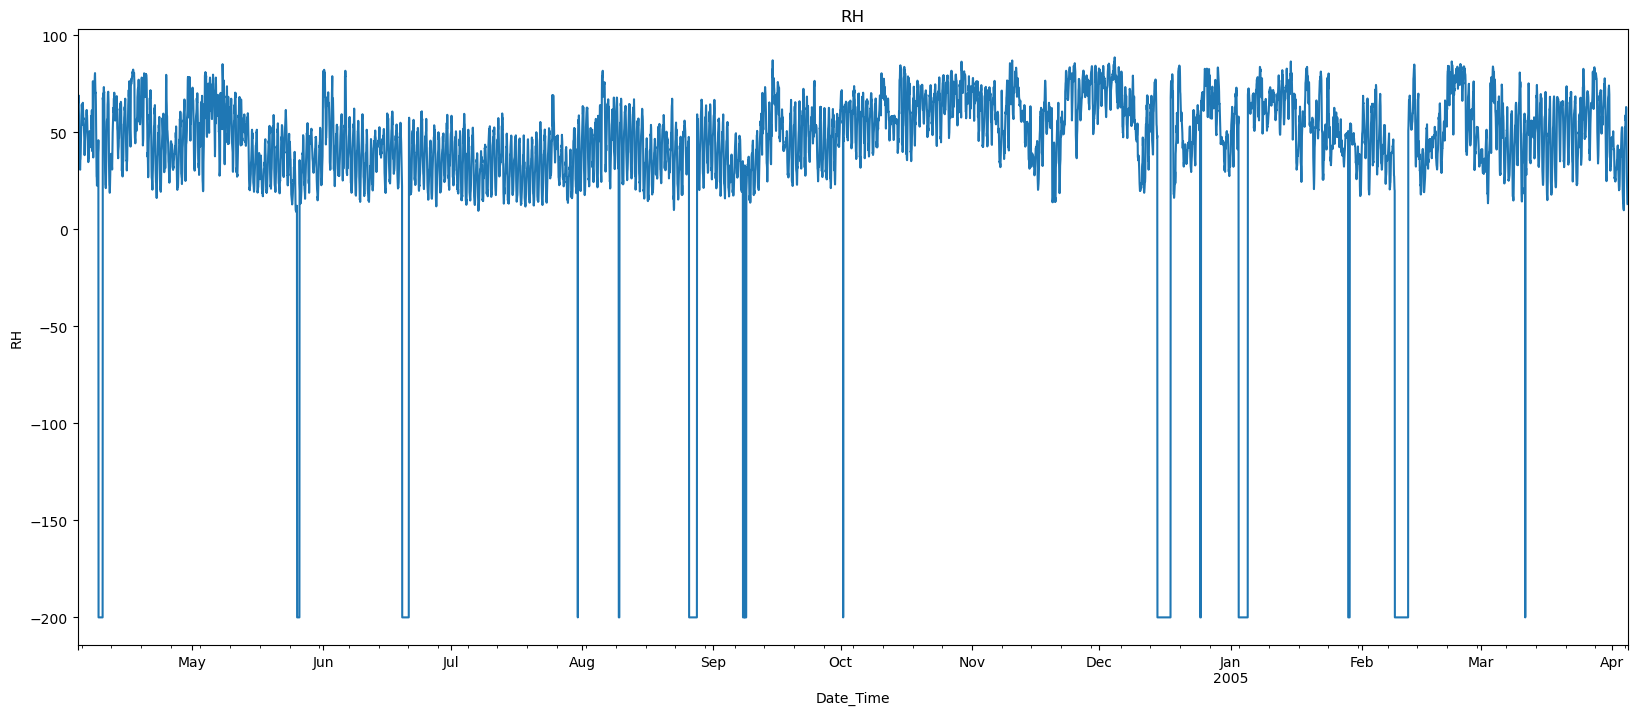

In [9]:
######################  Get some quick plots ################### 

for var in ['CO_sensor','RH']:
       data[var].plot(figsize=(20,8))
       plt.title(var)
       plt.ylabel(var)
       plt.show()

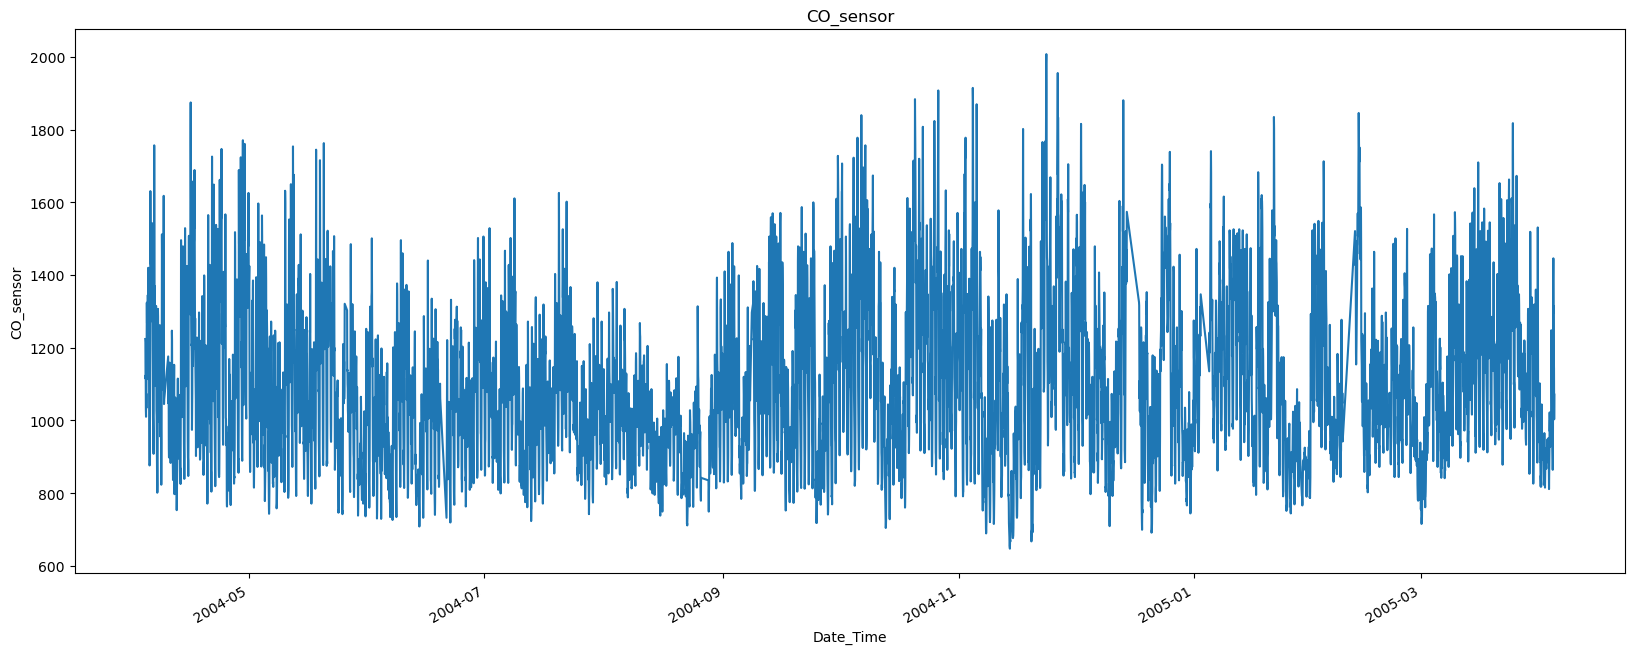

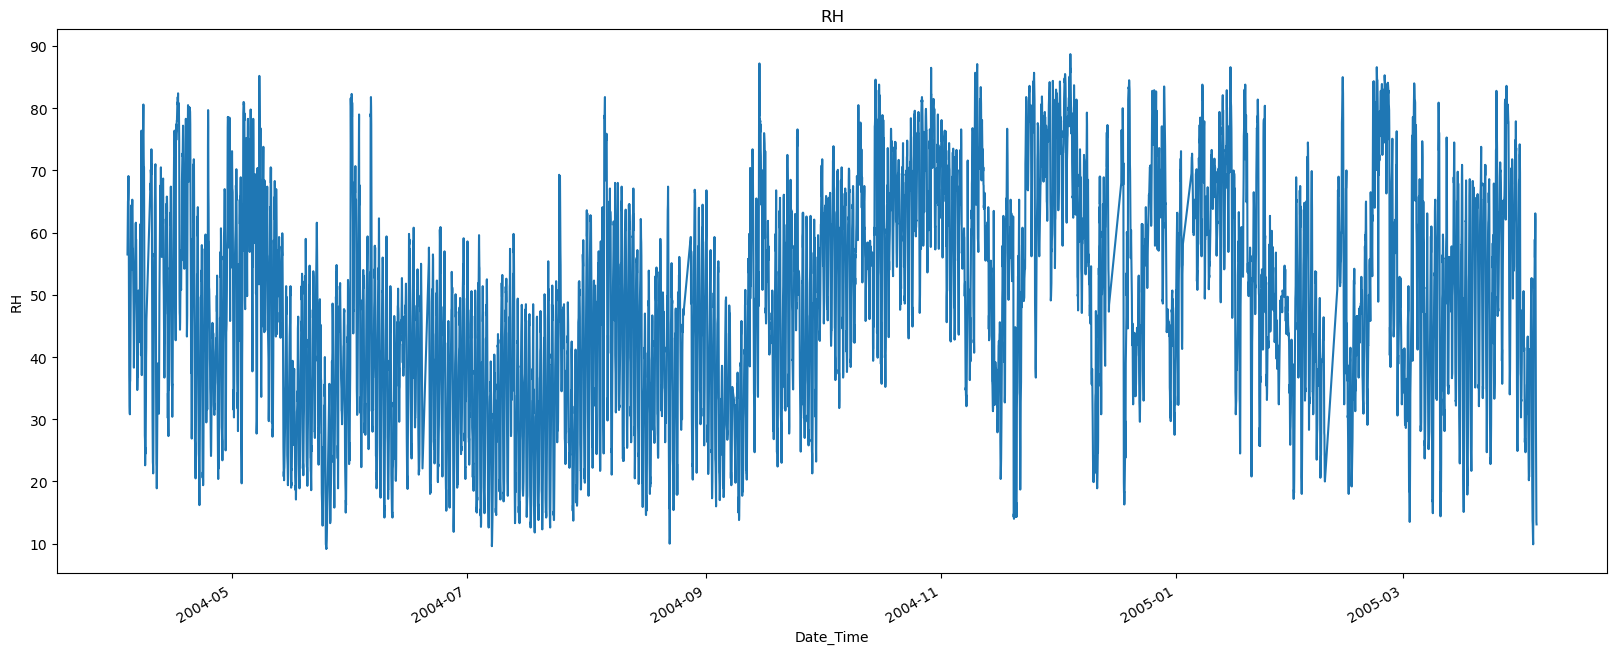

In [12]:
##################  Remove the outliers and get the same plots #########
data = data.loc[ (data["CO_sensor"]>=0) & (data['RH']>=0) ]


for var in ['CO_sensor','RH']:
       data[var].plot(figsize=(20,8))
       plt.title(var)
       plt.ylabel(var)
       plt.show()

C:\Users\Tharindu\AppData\Local\Temp\ipykernel_138384\3113119693.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_imputed = data_.fillna(method='ffill')  ## apply the forwardfill for missing values


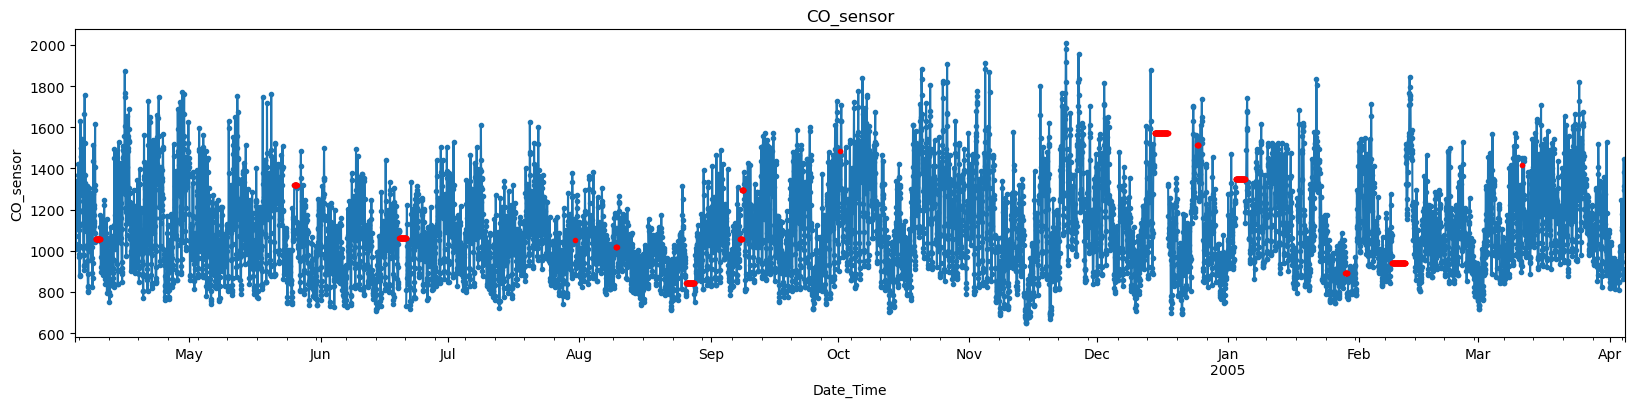

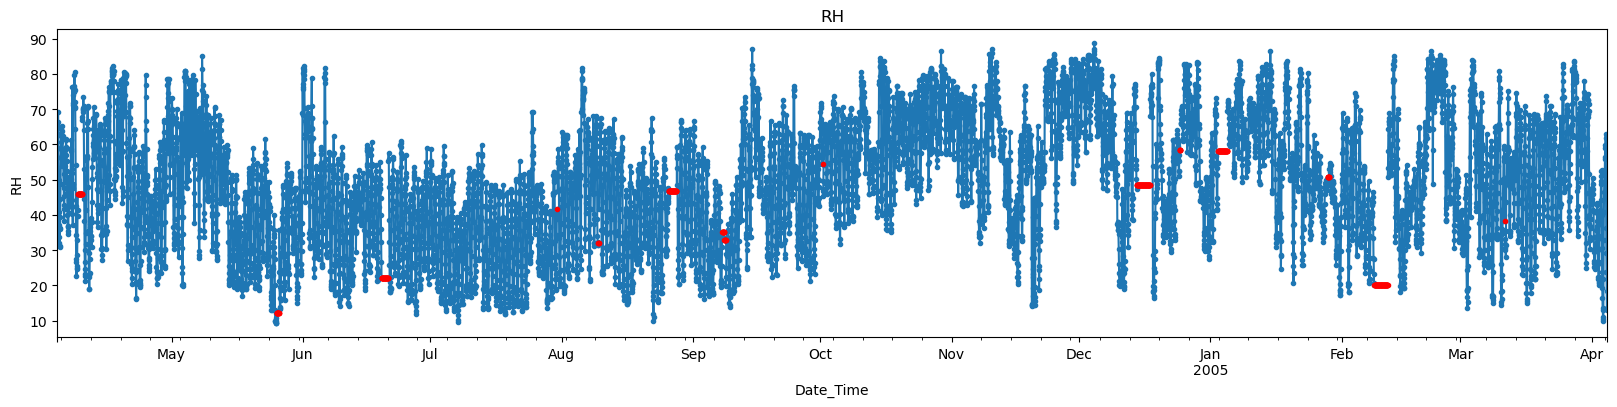

In [13]:
###################  Highlight the missing time stamps ############

data_ = data.asfreq('1H')
data_imputed = data_.fillna(method='ffill')  ## apply the forwardfill for missing values 

for var in ['CO_sensor','RH']:
       ax = data_[var].plot(linestyle='-',marker='.',figsize=[20,4])

       ## plot the imputed values on top in red
       data_imputed[data_.isnull()][var].plot(ax=ax,legend=None,marker=".",color='r')
       plt.title(var)
       plt.ylabel(var)
       plt.show()

Text(0, 0.5, 'Concentration')

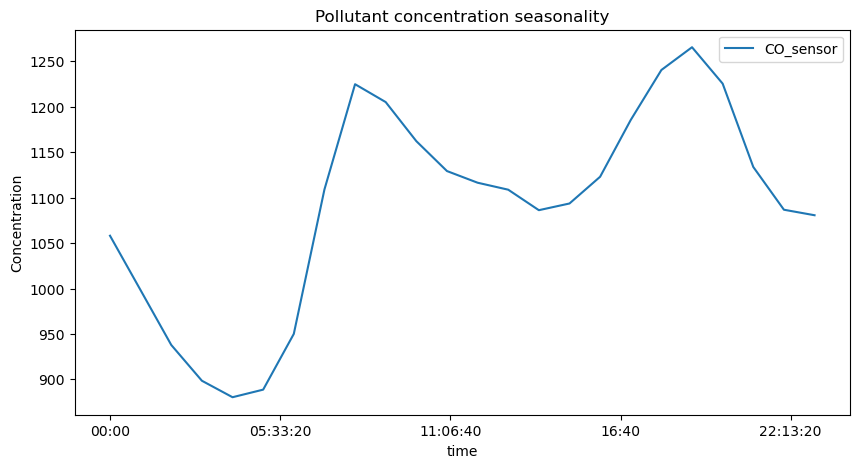

In [14]:
###### Check the patterns 

time_ = data.index.time
time_ = pd.Series(time_, index=data.index)
time_.head()


# Plot the average pollutant concentration per hour.

data.groupby(time_)[["CO_sensor"]].mean().plot(figsize=(10, 5))
plt.title("Pollutant concentration seasonality")
plt.ylabel("Concentration")

Text(0, 0.5, 'Concentration')

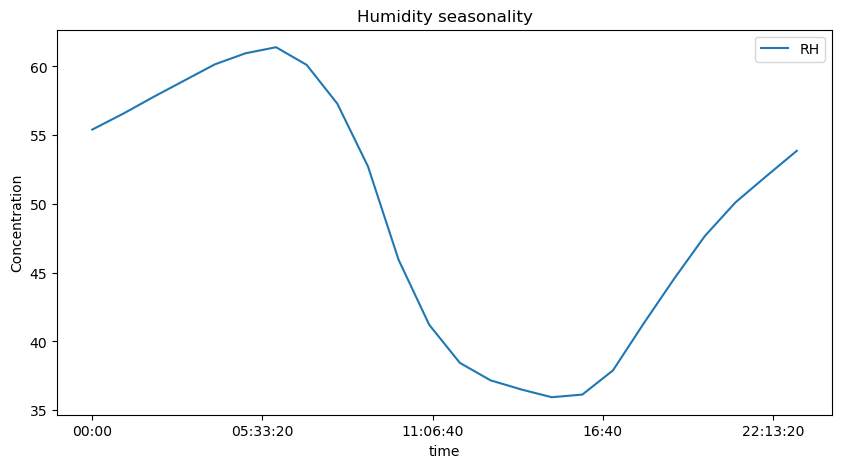

In [15]:
# Plot the average humidity per hour.

data.groupby(time_)[["RH"]].mean().plot(figsize=(10, 5))
plt.title("Humidity seasonality")
plt.ylabel("Concentration")

# Extracting time related features 

In [17]:
data["Month"] = data.index.month
data["Week"] = data.index.isocalendar().week
data["Day"] = data.index.day
data["Day_of_week"] = data.index.day_of_week
data["Hour"] = data.index.hour

# find out if it is a weekend.
data["is_weekend"] = np.where(data["Day_of_week"]>4, 1, 0)

# Show new variables
data.head(5)

,CO_sensor,RH,Month,Week,Day,Day_of_week,Hour,is_weekend
Date_Time,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,4,14,4,6,0,1
2004-04-04 01:00:00,1215.0,59.2,4,14,4,6,1,1
2004-04-04 02:00:00,1115.0,62.4,4,14,4,6,2,1
2004-04-04 03:00:00,1124.0,65.0,4,14,4,6,3,1
2004-04-04 04:00:00,1028.0,65.3,4,14,4,6,4,1


# Lag features 


* Lag features are past values of the variable that we can use to predict future values.
* Examples: The pollutant concentration for the previous hour (t-1) /  The pollutant concentration for the same hour on the previous day (t-24).

In [18]:
# raw time series
variables = ["CO_sensor", "RH"]

# Shift the data forward 1 Hr.
tmp = data[variables].shift(freq="1H")

# Names for the new variables.
tmp.columns = [v + "_lag_1" for v in variables]

# Add the variables to the original data.
print("data size before")
print(data.shape)

data = data.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(data.shape)

data.head()

data size before
(8412, 8)
data size after
(8412, 10)


,CO_sensor,RH,Month,Week,Day,Day_of_week,Hour,is_weekend,CO_sensor_lag_1,RH_lag_1
Date_Time,,,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,4,14,4,6,0,1,NaN,NaN
2004-04-04 01:00:00,1215.0,59.2,4,14,4,6,1,1,1224.0,56.5
2004-04-04 02:00:00,1115.0,62.4,4,14,4,6,2,1,1215.0,59.2
2004-04-04 03:00:00,1124.0,65.0,4,14,4,6,3,1,1115.0,62.4
2004-04-04 04:00:00,1028.0,65.3,4,14,4,6,4,1,1124.0,65.0


In [19]:
# In this procedure, we introduced missing
# data whenever there was no data available in
# the previous hour.

data.isnull().sum()

CO_sensor           0
RH                  0
Month               0
Week                0
Day                 0
Day_of_week         0
Hour                0
is_weekend          0
CO_sensor_lag_1    16
RH_lag_1           16
dtype: int64

In [21]:
# Move forward 24 hrs.
tmp = data[variables].shift(freq="24H")
tmp.columns = [v + "_lag_24" for v in variables]
data = data.merge(tmp, left_index=True, right_index=True, how="left")
data.head(5)



,CO_sensor,RH,Month,Week,Day,Day_of_week,Hour,is_weekend,CO_sensor_lag_1,RH_lag_1,CO_sensor_lag_24_x,RH_lag_24_x,CO_sensor_lag_24_y,RH_lag_24_y
Date_Time,,,,,,,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,4,14,4,6,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-04 01:00:00,1215.0,59.2,4,14,4,6,1,1,1224.0,56.5,NaN,NaN,NaN,NaN
2004-04-04 02:00:00,1115.0,62.4,4,14,4,6,2,1,1215.0,59.2,NaN,NaN,NaN,NaN
2004-04-04 03:00:00,1124.0,65.0,4,14,4,6,3,1,1115.0,62.4,NaN,NaN,NaN,NaN
2004-04-04 04:00:00,1028.0,65.3,4,14,4,6,4,1,1124.0,65.0,NaN,NaN,NaN,NaN


# Window featues 

<img src="../images/Screenshot 2024-05-12 001404.jpg" width="900" >

In [22]:
# Use the mean of the 3 previous hours as input variables.

tmp = (
    data[variables]
    .rolling(window="3H")
    .mean()  # Average the last 3 hr values.
    .shift(freq="1H")  # Move the average 1 hour forward
)

# Rename the columns
tmp.columns = [v + "_window" for v in variables]


# view of the result
tmp.head(10)

,CO_sensor_window,RH_window
Date_Time,,
2004-04-04 01:00:00,1224.000000,56.500000
2004-04-04 02:00:00,1219.500000,57.850000
2004-04-04 03:00:00,1184.666667,59.366667
2004-04-04 04:00:00,1151.333333,62.200000
2004-04-04 05:00:00,1089.000000,64.233333
2004-04-04 06:00:00,1054.000000,65.600000
2004-04-04 07:00:00,1037.333333,66.966667
2004-04-04 08:00:00,1039.333333,66.800000
2004-04-04 09:00:00,1079.333333,64.300000


In [23]:
# Join the new variables to the original data.
data = data.merge(tmp, left_index=True, right_index=True, how="left")
data.dropna(inplace=True)


# Periodic Features 

* Some features are periodic. For example, hours, months, and days.

* We can encode those periodic features using a sine and cosine transformation with the feature's period. This will cause the values of the features that are far apart to come closer. For example, December (12) is closer to January (1) than June (6). This relationship is not captured by the numerical representation of these features. But we could change it, if we transformed these variables with sine and cosine.

* We will discuss this technique later on in the course. For now, let's create these features automatically with the open source library Feature-engine.

In [26]:
# Create features that capture the cyclical representation.

cyclical = CyclicalFeatures(
    variables=["Month", "Hour"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

data = cyclical.fit_transform(data)
cyclical_vars = [var for var in data.columns if "sin" in var or "cos" in var]

data[cyclical_vars].head()

,Month_sin,Month_cos,Hour_sin,Hour_cos
Date_Time,,,,
2004-04-05 00:00:00,0.866025,-0.5,0.000000,1.000000
2004-04-05 01:00:00,0.866025,-0.5,0.269797,0.962917
2004-04-05 02:00:00,0.866025,-0.5,0.519584,0.854419
2004-04-05 03:00:00,0.866025,-0.5,0.730836,0.682553
2004-04-05 04:00:00,0.866025,-0.5,0.887885,0.460065
